In [14]:
from sklearn import tree
from sklearn import datasets
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

import numpy as np
import matplotlib.pyplot as plt

sample = []
label = []
NCA_d = []
SP_d = []
PM_d = []

for n in range(3):
    data = datasets.make_blobs(n_samples=300, n_features=2, centers=n+2, cluster_std=1.5, 
                   center_box=(-10.0, 10.0), shuffle=False, random_state=2)
    samples = data[0]
    labels = data[1]
    n_sample = samples.shape[0]
    n_feature = samples.shape[1]
    
    sample.append(samples)
    label.append(labels)
    
    clf = RandomTreesEmbedding(n_estimators=100, max_depth = 10)
    clf = clf.fit(samples)
    
    forest = clf.estimators_
    d = np.zeros([n_sample, n_sample])

    for k in range(100):
    
        tree = forest[k]
    
        path = tree.decision_path(samples).todense()
        n_nodes = tree.tree_.node_count
    
        for i in range(n_sample):
            for j in range(n_sample):
                sample_ids = [i, j]
                d[i, j] = d[i, j]+(path[sample_ids].sum(axis=0) == len(sample_ids)).sum()
            
            
    d = d/200
    d_Nearest_Common_Ancestor = [1/x for x in d]
    
    NCA_d.append(d_Nearest_Common_Ancestor)
    
    d = np.zeros([n_sample, n_sample])

    for k in range(100):
    
        tree = forest[k]
    
        path = tree.decision_path(samples).todense()
        n_nodes = tree.tree_.node_count
        l_children = tree.tree_.children_left
        r_children = tree.tree_.children_right
    
        node_depth = np.zeros(n_nodes)
        is_leaves = np.zeros(n_nodes)
        stack = [(0, -1)]
    
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()
            node_depth[node_id] = parent_depth + 1

            if (l_children[node_id] != r_children[node_id]):
                stack.append((l_children[node_id], parent_depth + 1))
                stack.append((r_children[node_id], parent_depth + 1))
            else:
                is_leaves[node_id] = 1
    
        for i in range(n_sample):
            for j in range(n_sample):
                sample_ids = [i, j]
                splitting_depth = (path[sample_ids].sum(axis=0) == len(sample_ids)).sum()
                leaf_i = tree.apply(samples[i].reshape(1, -1))
                leaf_j = tree.apply(samples[j].reshape(1, -1))
                d[i, j] = d[i, j]+node_depth[leaf_i]+node_depth[leaf_j]-2*splitting_depth
            
    d_ShortestPath = d/200
    
    SP_d.append(d_ShortestPath)
    
    Y = clf.transform(samples)
    prob = np.zeros([n_sample, n_sample])
    for i in range(n_sample):
        for j in range(n_sample):
            leaf_i = Y[i, :]
            leaf_j = Y[j, :]
            p = leaf_i.dot(leaf_j.transpose()).todense()
            prob[i, j] = p[0, 0]

    prob = 1 - prob / Y.shape[1]
    
    PM_d.append(prob)

0
1
2


<Figure size 720x720 with 0 Axes>

In [27]:
NCA_label = []
SP_label = []
PM_labelw = []
PM_labeld = []
NCA = []
SP = []
PM_ward = []
PM_distance = []

for i in range(3):
    cluster = AgglomerativeClustering(n_clusters=i+2, affinity="precomputed", linkage="complete")
    NCA_label.append(cluster.fit_predict(NCA_d[i]))
    NCA.append(adjusted_rand_score(label[i], NCA_label[i]))
    
for i in range(3):
    cluster = AgglomerativeClustering(n_clusters=i+2, affinity="precomputed", linkage="complete")
    SP_label.append(cluster.fit_predict(SP_d[i]))
    SP.append(adjusted_rand_score(label[i], SP_label[i]))

for i in range(3):
    cluster = AgglomerativeClustering(n_clusters=i+2, affinity="euclidean", linkage="ward")
    PM_labelw.append(cluster.fit_predict(PM_d[i]))
    PM_ward.append(adjusted_rand_score(label[i], PM_labelw[i]))
    cluster = AgglomerativeClustering(n_clusters=i+2, affinity="precomputed", linkage="average")
    PM_labeld.append(cluster.fit_predict(PM_d[i]))
    PM_distance.append(adjusted_rand_score(label[i], PM_labeld[i]))


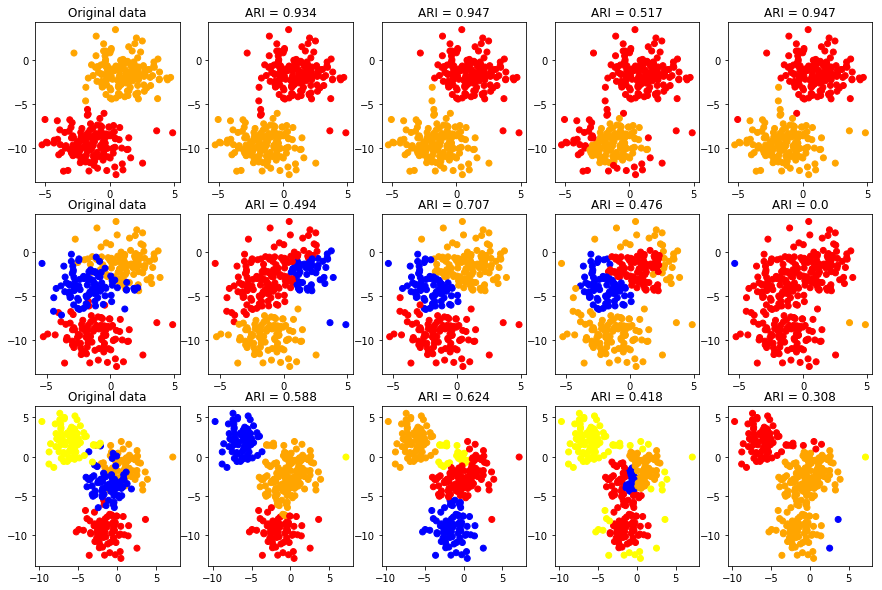

In [37]:
colors = np.array(['red', 'orange', 'blue', 'yellow'])
plt.figure(figsize=(15, 10))

for i in range(3):
    plt.subplot(3, 5, i*5+1)
    plt.scatter(sample[i][:, 0], sample[i][:, 1], color=colors[label[i]])
    plt.title('Original data')
    plt.subplot(3, 5, i*5+2)
    plt.scatter(sample[i][:, 0], sample[i][:, 1], color=colors[NCA_label[i]])
    plt.title('ARI = '+str(round(NCA[i], 3)))
    plt.subplot(3, 5, i*5+3)
    plt.scatter(sample[i][:, 0], sample[i][:, 1], color=colors[SP_label[i]])
    plt.title('ARI = '+str(round(SP[i], 3)))
    plt.subplot(3, 5, i*5+4)
    plt.scatter(sample[i][:, 0], sample[i][:, 1], color=colors[PM_labelw[i]])
    plt.title('ARI = '+str(round(PM_ward[i], 3)))
    plt.subplot(3, 5, i*5+5)
    plt.scatter(sample[i][:, 0], sample[i][:, 1], color=colors[PM_labeld[i]])
    plt.title('ARI = '+str(round(PM_distance[i], 3)))

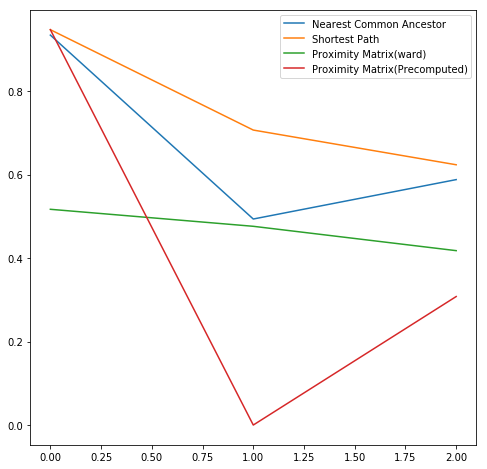

In [41]:
plt.figure(figsize=(8, 8))

plt.plot(NCA, label='Nearest Common Ancestor')
plt.plot(SP, label='Shortest Path')
plt.plot(PM_ward, label='Proximity Matrix(ward)')
plt.plot(PM_distance, label='Proximity Matrix(Precomputed)')

plt.legend()